## [ISIC 2024 - Skin Cancer Detection with 3D-TBP](https://www.kaggle.com/competitions/isic-2024-challenge/overview)
##### Lingfeng (Ling) Su, Manal Amarsaikhan, Yuxin (Katy) Chen, Keelan Gan

In [274]:
# Standard Library Imports
import os
import math
import random

# Third-Party Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import RobustScaler, MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from tabulate import tabulate
from tqdm.notebook import tqdm
import h5py
import cv2
from PIL import Image, ImageEnhance, ImageOps

# TensorFlow and Keras Imports
import tensorflow as tf
from tensorflow.keras import layers
import keras_cv
import keras

#### Dataset Summary Statistics

In [2]:
metadata = pd.read_csv("isic-2024-challenge/train-metadata.csv", low_memory=False)

print("---------------------------------------Shape-------------------------------------------------")
print(metadata.shape)
print("---------------------------------------Info--------------------------------------------------")
print(metadata.info())
print("---------------------------------------Describe----------------------------------------------")
print(metadata.describe())
print("---------------------------------------Missing Data------------------------------------------")
print(metadata.isnull().sum())

---------------------------------------Shape-------------------------------------------------
(401059, 55)
---------------------------------------Info--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A               

#### Class Distribution Before Processing

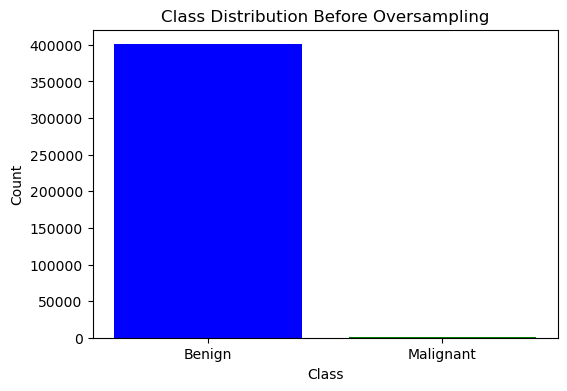

In [3]:
# Count class instances before oversampling
class_counts = metadata['target'].value_counts()

# Plot class distribution before oversampling
plt.figure(figsize=(6, 4))
plt.bar(class_counts.index, class_counts.values, color=['blue', 'green'])
plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution Before Oversampling")
plt.show()

In [4]:
# Define numerical columns for outlier detection
numeric_cols = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
    'tbp_lv_minorAxisMM', 'tbp_lv_perimeterMM', 'tbp_lv_deltaLBnorm',
    'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_radial_color_std_max',
    'tbp_lv_symm_2axis', "tbp_lv_color_std_mean", "tbp_lv_nevi_confidence"
]
# Compute Z-scores
z_scores = np.abs(stats.zscore(metadata[numeric_cols]))

# Set threshold (e.g., values greater than 3 std deviations)
threshold = 3
outliers_zscore = metadata[(z_scores > threshold).any(axis=1)]

print(f"Number of outliers detected using Z-Score: {len(outliers_zscore)}")

Number of outliers detected using Z-Score: 29018


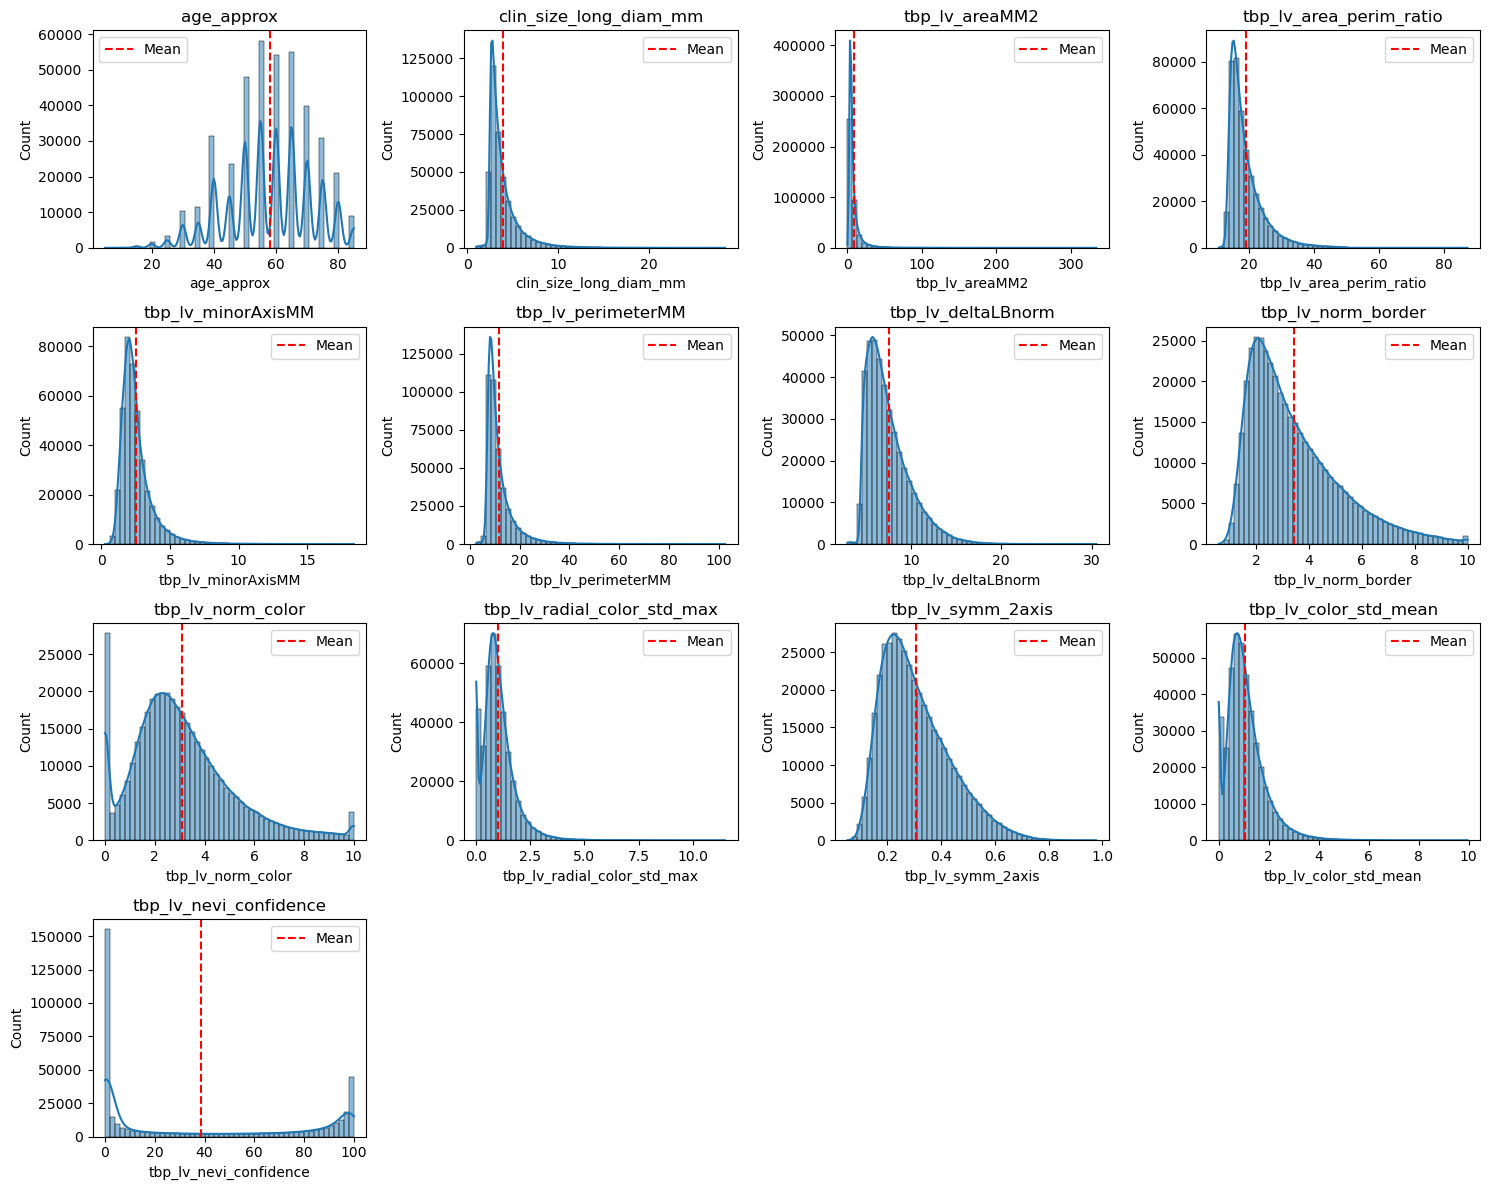

In [5]:
# Plot histograms for all selected numerical features
plt.figure(figsize=(15, 12))

for i, col in enumerate(numeric_cols):
    plt.subplot(4, 4, i+1)  # Adjust layout based on the number of features
    sns.histplot(metadata[col], bins=50, kde=True)
    plt.axvline(metadata[col].mean(), color='red', linestyle='dashed', label='Mean')
    plt.title(col)
    plt.legend()

plt.tight_layout()
plt.show()

#### Process Metadata

1. **Removed Unnecessary Columns**:
   - Dropped columns that are only relevant to training data or contain redundant information.
   - Columns removed: `lesion_id`, `iddx_2`, `iddx_3`, `iddx_4`, `iddx_5`, `mel_mitotic_index`, `mel_thick_mm`, `patient_id`, `image_type`, `attribution`, `copyright_license`, `tbp_lv_dnn_lesion_confidence`, `iddx_1`, `iddx_full`.
   
2. **Handled Missing Values**:
   - Removed rows with missing values in critical columns: `age_approx`, `anatom_site_general`, `sex` to ensured the dataset is complete and ready for further processing.

3. **Handled outliers**: For our dataset, we will handle outliers based on their impact and biological validity. 
    - Outliers in patient age (`age_approx`) are filtered if they are below 5 or above 100, as they are likely errors. 
    - For lesion size-related features (`clin_size_long_diam_mm`, `tbp_lv_areaMM2`, `tbp_lv_minorAxisMM`, `tbp_lv_perimeterMM`), we remove implausible values and apply Winsorization to cap extreme values at the 1st and 99th percentiles. 
    - Features related to lesion border irregularity, color variation, and asymmetry (`tbp_lv_norm_border`, `tbp_lv_norm_color`, `tbp_lv_radial_color_std_max`, `tbp_lv_symm_2axis`) may contain valuable diagnostic information, so instead of removing outliers, we apply Robust Scaling to reduce their influence. This approach ensures we retain meaningful patterns in the data while reducing the impact of extreme values.

4. **Encoded Categorical Features**:
   - Applied one-hot encoding to categorical features using `OneHotEncoder`. The encoder is fitted on the training data and reused for the test data to ensure consistency.

5. **Discretized Age Feature**:
   - Discretized the `age_approx` feature into 5 bins and converted it to a float type for numerical processing.

6. **Normalized Numerical Features**:
   - Applied `Min-Max` scaling to normalize numerical features, ensuring all features are on a similar scale for model training.

7. **Balanced the Dataset**:
   - Oversampled minority class and downsampled majority class using TrainingConfig ratios.
   - Shuffled dataset to ensure randomness.

##### Key Insights
- The dataset has been cleaned and preprocessed to ensure high data quality, with irrelevant columns and missing values removed.
- Outliers have been handled appropriately, with Winsorization and Robust Scaling applied to retain meaningful patterns while reducing the impact of extreme values.
- Categorical features have been consistently encoded, and numerical features have been normalized for model training.
- The dataset has been balanced to address class imbalance, ensuring the model can learn effectively from both minority and majority classes. We will utilize class weights during model training to address the class imbalance, ensuring the model appropriately prioritizes the minority class.

In [190]:
class TrainingConfig:
    """
    Configuration class for training and model setup.
    """
    verbose = 1  
    seed = 42 
    batch_size = 32
    majority_ratio = 0.7
    minority_ratio = 0.3
    preset = "efficientnetv2_b2_imagenet"
    image_size = [100, 100]
    lr_mode = "cos"  # Learning rate scheduler mode: "cos", "step", or "exp"
    class_names = ['target']
    num_classes = 1
    sample_size = 0.3

In [171]:
# Categorical features which will be one hot encoded
CATEGORICAL_COLUMNS = ["sex", "anatom_site_general",
            "tbp_tile_type","tbp_lv_location", "tbp_lv_location_simple"]

# Numeraical features which will be normalized
NUMERIC_COLUMNS = [
    'age_approx', 'clin_size_long_diam_mm', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
    'tbp_lv_minorAxisMM', 'tbp_lv_perimeterMM', 'tbp_lv_deltaLBnorm',
    'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_radial_color_std_max',
    'tbp_lv_symm_2axis', "tbp_lv_color_std_mean", "tbp_lv_nevi_confidence"]

# Tabular feature columns
FEAT_COLS = CATEGORICAL_COLUMNS + NUMERIC_COLUMNS

In [334]:
def preprocess_metadata(metadata, minority_ratio, majority_ratio, seed, train=True, encoder=None, scaler=None):
    """
    Preprocess the metadata for the ISIC 2024 challenge.
    """
    
    # Remove unnecessary columns (only for training data)
    if train:
        columns_to_drop = [
            'lesion_id', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index',
            'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence', 'iddx_1', 'iddx_full',
            'patient_id', 'image_type', 'attribution', 'copyright_license'
        ]
        metadata = metadata.drop(columns=columns_to_drop)

        # Filter out rows with missing values in key columns (only for training data)
        metadata = metadata.dropna(subset=['age_approx', 'anatom_site_general', 'sex'])

        # Filter biologically implausible age values (only for training data)
        metadata = metadata[(metadata['age_approx'] >= 5) & (metadata['age_approx'] <= 100)]
    else:
        columns_to_drop = ['patient_id', 'image_type', 'attribution', 'copyright_license']
        metadata = metadata.drop(columns=columns_to_drop)
        
    # Apply Winsorization to lesion size-related features
    size_cols = ['clin_size_long_diam_mm', 'tbp_lv_areaMM2', 'tbp_lv_minorAxisMM', 'tbp_lv_perimeterMM']
    for col in size_cols:
        metadata[col] = winsorize(metadata[col], limits=[0.01, 0.01])  # Cap at 1st and 99th percentile

    # Apply RobustScaler to features where outliers may be informative
    scale_cols = [
        'tbp_lv_area_perim_ratio', 'tbp_lv_deltaLBnorm', 'tbp_lv_norm_border',
        'tbp_lv_norm_color', 'tbp_lv_radial_color_std_max', 'tbp_lv_symm_2axis'
    ]
    r_scaler = RobustScaler()
    metadata[scale_cols] = r_scaler.fit_transform(metadata[scale_cols])
    
    # Hot encode categorical features
    if train:
        # Fit the OneHotEncoder on the training data
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_categories = encoder.fit_transform(metadata[CATEGORICAL_COLUMNS])
        encoded_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(CATEGORICAL_COLUMNS), index=metadata.index)
    else:
        # Transform the test data using the encoder fitted on the training data
        encoded_categories = encoder.transform(metadata[CATEGORICAL_COLUMNS])
        encoded_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(CATEGORICAL_COLUMNS), index=metadata.index)
        
    # Drop the original categorical columns and concatenate the encoded ones
    metadata = metadata.drop(columns=CATEGORICAL_COLUMNS)
    metadata = pd.concat([metadata, encoded_df], axis=1)
    
    # Discritize age feature
    metadata['age_approx'] = pd.cut(metadata['age_approx'], bins=5, labels=False)
    metadata['age_approx'] = metadata['age_approx'].astype(float)
    
    # Normalize numerical features
    if train:
        scaler = MinMaxScaler()
        metadata[NUMERIC_COLUMNS[1:]] = scaler.fit_transform(metadata[NUMERIC_COLUMNS[1:]])
    else:
        if scaler is None:
            raise ValueError("Scaler must be provided for test data preprocessing.")
        metadata[NUMERIC_COLUMNS[1:]] = scaler.transform(metadata[NUMERIC_COLUMNS[1:]])

    # Balance the dataset by sampling minority and majority classes (only for training data)
    if train:
        original_minority_ratio = metadata['target'].mean()
        minority_class = metadata.query("target == 1").sample(
            frac=minority_ratio / original_minority_ratio, random_state=seed, replace=True
        )
        majority_class = metadata.query("target == 0").sample(
            frac=majority_ratio, random_state=seed
        )
        metadata = pd.concat([minority_class, majority_class], axis=0).reset_index(drop=True)

    return metadata, encoder, scaler

In [335]:
metadata = pd.read_csv("isic-2024-challenge/train-metadata.csv", low_memory=False)
df, t_encoder, t_scaler = preprocess_metadata(metadata, TrainingConfig.minority_ratio, TrainingConfig.majority_ratio, TrainingConfig.seed)

#### Class Distribution After Processing

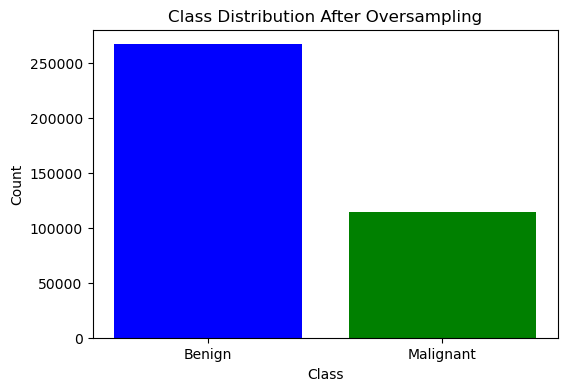

,isic_id,target,age_approx,clin_size_long_diam_mm,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,...,tbp_lv_location_Torso Front,tbp_lv_location_Torso Front Bottom Half,tbp_lv_location_Torso Front Top Half,tbp_lv_location_simple_Head & Neck,tbp_lv_location_simple_Left Arm,tbp_lv_location_simple_Left Leg,tbp_lv_location_simple_Right Arm,tbp_lv_location_simple_Right Leg,tbp_lv_location_simple_Torso Back,tbp_lv_location_simple_Torso Front
0,ISIC_3005303,1,4.0,0.327907,14.233970,13.405580,14.309860,19.655870,20.18361,23.792070,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,ISIC_8898380,1,4.0,0.309302,32.052400,21.253250,24.043740,25.111570,40.06816,32.898200,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,ISIC_7031844,1,3.0,0.281395,30.535701,23.649522,21.781311,25.160111,37.50806,34.530148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,ISIC_3121355,1,4.0,0.698837,28.902000,18.068450,27.255490,28.206650,39.72641,33.497520,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,ISIC_1741809,1,3.0,0.000000,37.682790,28.896440,25.184650,23.301620,45.32393,37.121010,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [337]:
# Count class instances after oversampling
class_counts = df['target'].value_counts()

# Plot class distribution after oversampling
plt.figure(figsize=(6, 4))
plt.bar(class_counts.index, class_counts.values, color=['blue', 'green'])
plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution After Oversampling")
plt.show()

# Display the first few rows of the preprocessed metadata
df.head()

#### Image Sample With Properties

In [338]:
BASE_PATH = "isic-2024-challenge"
training_validation_hdf5 = h5py.File(f"{BASE_PATH}/train-image.hdf5", 'r')
testing_hdf5 = h5py.File(f"{BASE_PATH}/test-image.hdf5", 'r')

Byte String: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00'....


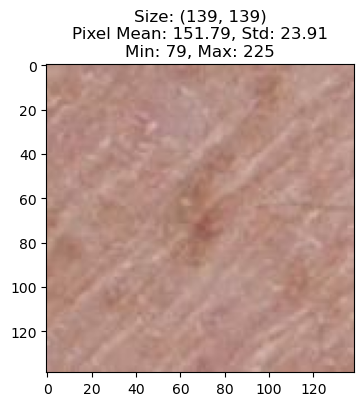

In [339]:
isic_id = metadata['isic_id'].iloc[0]

# Image as Byte String
byte_string = training_validation_hdf5[isic_id][()]
print(f"Byte String: {byte_string[:20]}....")

# Convert byte string to numpy array
nparr = np.frombuffer(byte_string, np.uint8)
image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)[...,::-1] # reverse last axis for bgr -> rgb
image_size = image.shape[:2]

# Compute image statistics
pixel_mean = image.mean()
pixel_std = image.std()
pixel_min = image.min()
pixel_max = image.max()

# Display the image with properties
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.title(f"Size: {image_size}\n" f"Pixel Mean: {pixel_mean:.2f}, Std: {pixel_std:.2f}\n" f"Min: {pixel_min}, Max: {pixel_max}")
plt.show()

#### Dataset Preprocessing Steps

1. **Splitting the Dataset**
    - Used `GroupShuffleSplit` to split the dataset into training (80%) and validation (20%) sets while ensuring grouped samples stay together(e.g., images of the same isic_id), preventing data leakage.

2. **Building an Image Augmenter**
    - Created a Keras-based augmenter with random flip, cutout, contrast, brightness, and zoom.

3. **Building an Image Decoder**
    - Implemented a function to decode JPEG images, resize them to `target_size`, normalize pixel values, and reshape them.

4. **Creating TensorFlow Datasets**
    - Created a TensorFlow dataset containing images, features, and labels.
    - Applied caching, shuffling, batching, and prefetching to optimize training.
    - Used data augmentation only for training while keeping validation images unaltered.

5. **Initializing Training and Validation Datasets**
   - Built TensorFlow datasets using the defined functions, enabling efficient training and validation.

In [340]:
# Initialize GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=TrainingConfig.seed)

# Random sample of the data
df_sample = df.sample(frac=TrainingConfig.sample_size, random_state=TrainingConfig.seed)

# Split the data
train_idx, val_idx = next(gss.split(df_sample, groups=df_sample['isic_id']))

# Create training and validation DataFrames
training_df = df_sample.iloc[train_idx]
validation_df = df_sample.iloc[val_idx]

print(f"# Num Train: {len(training_df)} | Num Valid: {len(validation_df)}")

# Num Train: 91953 | Num Valid: 22541


In [286]:
def buid_augmenter():
    """
    Build an image augmenter using the Keras Sequential API.
    """
    aug_layers = [
        keras_cv.layers.RandomFlip("horizontal"),
        keras_cv.layers.RandomCutout(height_factor=(0.02, 0.06), width_factor=(0.02, 0.06)),
        keras_cv.layers.RandomContrast(factor=0.1, value_range=(0, 1)),
        keras_cv.layers.RandomBrightness(factor=0.1, value_range=(0, 1)),
        keras_cv.layers.RandomZoom(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1)),
    ]

    # Apply augmentations to random samples
    aug_layers = [keras_cv.layers.RandomApply(x, rate=0.5) for x in aug_layers]
    
    # Build the augment layer
    augmenter = keras_cv.layers.Augmenter(aug_layers)
    
    # Apply augmentations
    def augment(inp, label):
        images = inp["images"]
        aug_data = {"images": images}
        aug_data = augmenter(aug_data)
        inp["images"] = aug_data["images"]
        return inp, label
    return augment

In [288]:
def build_decoder(with_labels=True, target_size=TrainingConfig.image_size):
    """
    Create a function to decode images and optionally labels.
    """
    def decode_image(inp):
        # Read jpeg image
        file_bytes = inp["images"]
        image = tf.io.decode_jpeg(file_bytes)
        
        # Resize
        image = tf.image.resize(image, size=target_size, method="area")
        
        # Normalize
        image = tf.cast(image, tf.float32)
        image /= 255.0
        
        # Reshape
        image = tf.reshape(image, [*target_size, 3])
        
        inp["images"] = image
        return inp

    def decode_label(label, num_classes):
        label = tf.cast(label, tf.float32)
        label = tf.reshape(label, [num_classes])
        return label

    def decode_with_labels(inp, label=None):
        inp = decode_image(inp)
        label = decode_label(label, num_classes=TrainingConfig.num_classes)
        return (inp, label)

    return decode_with_labels if with_labels else decode_image

In [289]:
def build_dataset(
    isic_ids,
    hdf5,
    features,
    labels=None,
    batch_size=32,
    decode_fn=None,
    augment_fn=None,
    augment=False,
    shuffle=1024,
    cache=True,
    drop_remainder=False,
):
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)

    if augment_fn is None:
        augment_fn = buid_augmenter()

    AUTO = tf.data.experimental.AUTOTUNE

    images = [None]*len(isic_ids)
    for i, isic_id in enumerate(tqdm(isic_ids, desc="Loading Images ")):
        images[i] = hdf5[isic_id][()]
        
    features = np.array(features, dtype=np.float32)
    
    inp = {"images": images, "features": features}
    slices = (inp, labels) if labels is not None else inp

    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.cache() if cache else ds
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    if shuffle:
        ds = ds.shuffle(shuffle, seed=TrainingConfig.seed)
        opt = tf.data.Options()
        opt.deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

In [341]:
# Train
print("# Training:")
training_features = np.array(training_df.drop(columns=["isic_id", "target"]).values.tolist())
training_ids = training_df.isic_id.values
training_labels = training_df.target.values
training_ds = build_dataset(training_ids, training_validation_hdf5, training_features, 
                         training_labels, batch_size=TrainingConfig.batch_size,
                         shuffle=True, augment=True)

# Valid
print("# Validation:")
validation_features = np.array(validation_df.drop(columns=["isic_id", "target"]).values.tolist())
validation_ids = validation_df.isic_id.values
validation_labels = validation_df.target.values
validation_ds = build_dataset(validation_ids, training_validation_hdf5, validation_features,
                         validation_labels, batch_size=TrainingConfig.batch_size,
                         shuffle=False, augment=False)

# Training:


Loading Images :   0%|          | 0/91953 [00:00<?, ?it/s]

# Validation:


Loading Images :   0%|          | 0/22541 [00:00<?, ?it/s]

In [291]:
print("Training Dataset:")
for x, y in training_ds.take(1):
    print("images.shape:", x["images"].shape)
    feat = x["features"]
    print("features.shape:", feat.shape)
    print("features.dtype:", feat.dtype)
    print("label.shape:", y.shape)

print("\nValidation Dataset:")  
for x, y in validation_ds.take(1):
    print("images.shape:", x["images"].shape)
    feat = x["features"]
    print("features.shape:", feat.shape)
    print("features.dtype:", feat.dtype)
    print("label.shape:", y.shape)

Training Dataset:
images.shape: (32, 100, 100, 3)
features.shape: (32, 70)
features.dtype: <dtype: 'float32'>
label.shape: (32, 1)

Validation Dataset:
images.shape: (32, 100, 100, 3)
features.shape: (32, 70)
features.dtype: <dtype: 'float32'>
label.shape: (32, 1)


In [292]:
training_ds = training_ds.map(
    lambda x, y: ({"images": x["images"],
                   "features": x["features"]}, y), num_parallel_calls=tf.data.AUTOTUNE)

validation_ds = validation_ds.map(
    lambda x, y: ({"images": x["images"],
                   "features": x["features"]}, y), num_parallel_calls=tf.data.AUTOTUNE)

Images Shape: (32, 100, 100, 3)
Labels Shape: (32, 1)


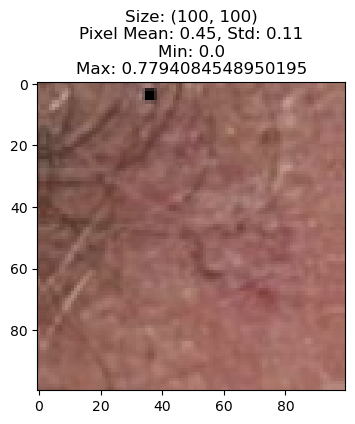

In [293]:
for images, labels in training_ds.take(1):
    print(f"Images Shape: {images['images'].shape}")
    print(f"Labels Shape: {labels.shape}")
    break

image = images['images'][0].numpy()
image_size = image.shape[:2]

# Compute image statistics
pixel_mean = image.mean()
pixel_std = image.std()
pixel_min = image.min()
pixel_max = image.max()

# Display the image with properties
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.title(f"Size: {image_size}\n" f"Pixel Mean: {pixel_mean:.2f}, Std: {pixel_std:.2f}\n" f"Min: {pixel_min}\n" f"Max: {pixel_max}")
plt.show()

In [343]:
image_input = keras.Input(shape=(*TrainingConfig.image_size, 3), name="images")
feat_input = keras.Input(shape=(len(df.columns) - 2,), name="features")
inp = {"images":image_input, "features":feat_input}

# Branch for image input
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(TrainingConfig.preset)
x1 = backbone(image_input)
x1 = keras.layers.GlobalAveragePooling2D()(x1)
x1 = keras.layers.Dropout(0.2)(x1)

# Branch for tabular/feature input
x2 = keras.layers.Dense(96, activation="selu")(feat_input)
x2 = keras.layers.Dense(128, activation="selu")(x2)
x2 = keras.layers.Dropout(0.1)(x2)

# Concatenate both branches
concat = keras.layers.Concatenate()([x1, x2])

# Output layer
out = keras.layers.Dense(1, activation="sigmoid", dtype="float32")(concat)

# Build model
model = keras.models.Model(inp, out)

# Compile the model
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=1e-5, clipnorm=1.0),
    loss=keras.losses.BinaryCrossentropy(label_smoothing=0.01, from_logits=True),
    metrics=[keras.metrics.AUC(name="auc")]
)

# Model Summary
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer) │ (None, 100, 100,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ features            │ (None, 70)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficient_net_v2b2… │ (None, 4, 4,      │  8,769,374 │ images[0][0]      │
│ (EfficientNetV2Bac… │ 1408)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 96)        │      6,816 │ features[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1408)      │          0 │ efficient_net_v2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 128)       │     12,416 │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 1408)      │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 128)       │          0 │ dense_31[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 1536)      │          0 │ dropout_20[0][0], │
│ (Concatenate)       │                   │            │ dropout_21[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 1)         │      1,537 │ concatenate_10[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,790,143 (33.53 MB)

 Trainable params: 8,707,855 (33.22 MB)

 Non-trainable params: 82,288 (321.44 KB)

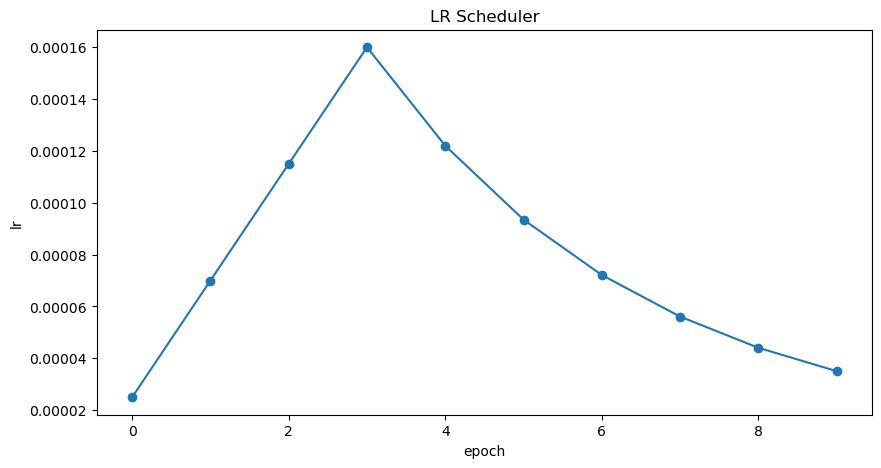

In [344]:
def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 2.5e-5, 5e-6 * batch_size, 0.8e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

lr_cb = get_lr_callback(TrainingConfig.batch_size, mode="exp", plot=True)

In [345]:
ckpt_cb = keras.callbacks.ModelCheckpoint(
    "best_model.keras",   # Filepath where the model will be saved.
    monitor="val_auc",    # Metric to monitor (validation AUC in this case).
    save_best_only=True,  # Save only the model with the best performance.
    save_weights_only=False,  # Save the entire model (not just the weights).
    mode="max",           # The model with the maximum 'val_auc' will be saved.
)
es_cb = keras.callbacks.EarlyStopping(
    monitor="val_auc",   # Monitor validation AUC
    patience=3,          # Number of epochs with no improvement before stopping
    mode="max",          # Stop when 'val_auc' is no longer increasing
    restore_best_weights=True # Restore best weights when stopping
)
reduce_lr_cb = keras.callbacks.ReduceLROnPlateau( 
    monitor="val_auc", 
    factor=0.5, 
    patience=3, 
    min_lr=1e-6, 
    verbose=1 
)

In [347]:
majority_weight = 1 / TrainingConfig.majority_ratio
minority_weight = 1 / TrainingConfig.minority_ratio
class_weights = {0: majority_weight, 1: minority_weight}

# Train the model with class weights
CNN_Model = model.fit(
    training_ds,
    epochs=10,  # Increased number of epochs
    callbacks=[lr_cb, ckpt_cb, es_cb, reduce_lr_cb],
    steps_per_epoch=150,
    validation_data=validation_ds,
    validation_steps=50,  # Reduced validation steps for faster debugging
    verbose=1,
    shuffle=True,
    class_weight=class_weights,
)

Epoch 1/10
 30/150 ━━━━━━━━━━━━━━━━━━━━ 6:39 3s/step - auc: 0.4927 - loss: 7.2723

KeyboardInterrupt: 

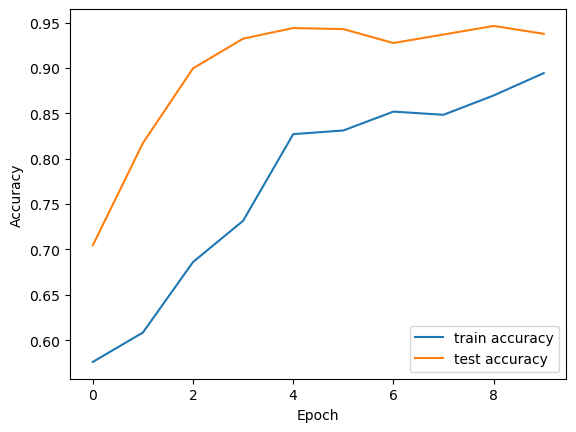

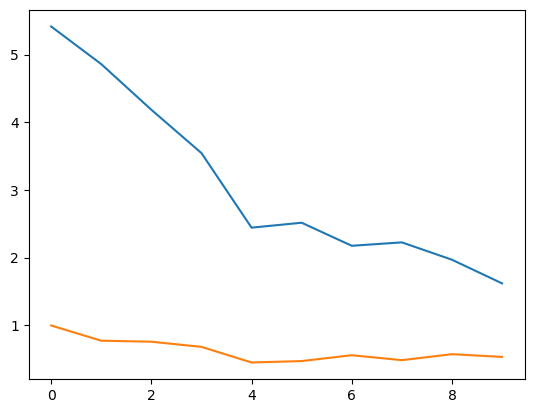

In [210]:
plt.plot(CNN_Model.history['auc'], label='train accuracy')
plt.plot(CNN_Model.history['val_auc'], label = 'test accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.legend(); plt.show()

plt.plot(CNN_Model.history['loss'], label='train loss')
plt.plot(CNN_Model.history['val_loss'], label = 'test loss')

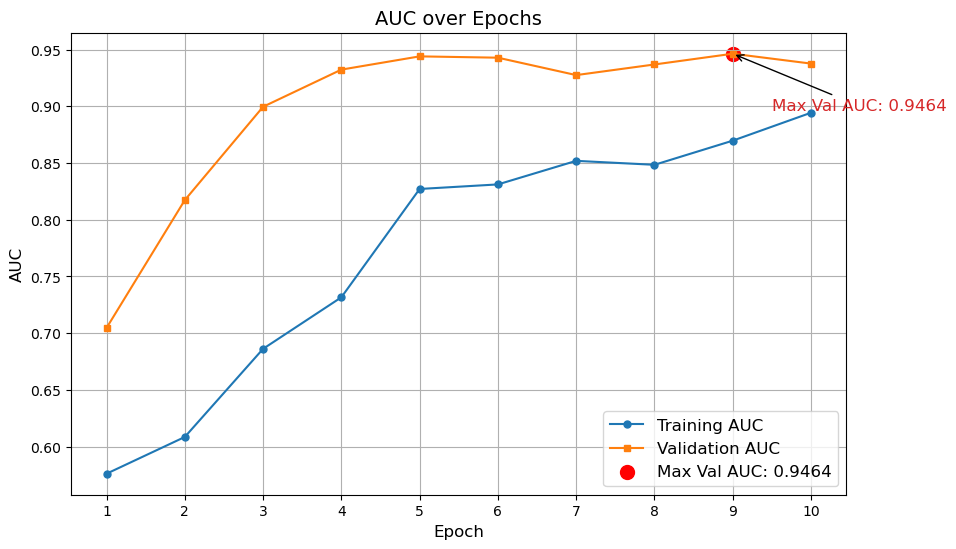

In [211]:
# Extract AUC and validation AUC from history
auc = CNN_Model.history['auc']
val_auc = CNN_Model.history['val_auc']
epochs = range(1, len(auc) + 1)

# Find the epoch with the maximum val_auc
max_val_auc_epoch = np.argmax(val_auc)
max_val_auc = val_auc[max_val_auc_epoch]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, auc, 'o-', label='Training AUC', markersize=5, color='tab:blue')
plt.plot(epochs, val_auc, 's-', label='Validation AUC', markersize=5, color='tab:orange')

# Highlight the max val_auc
plt.scatter(max_val_auc_epoch + 1, max_val_auc, color='red', s=100, label=f'Max Val AUC: {max_val_auc:.4f}')
plt.annotate(f'Max Val AUC: {max_val_auc:.4f}', 
             xy=(max_val_auc_epoch + 1, max_val_auc), 
             xytext=(max_val_auc_epoch + 1 + 0.5, max_val_auc - 0.05),
             arrowprops=dict(facecolor='black', arrowstyle="->"),
             fontsize=12,
             color='tab:red')

# Enhancing the plot
plt.title('AUC over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('AUC', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.xticks(epochs)

# Show the plot
plt.show()

In [212]:
# Best Result
best_score = max(CNN_Model.history['val_auc'])
best_epoch = np.argmax(CNN_Model.history['val_auc']) + 1
print("#" * 10 + " Result " + "#" * 10)
print(f"Best AUC: {best_score:.5f}")
print(f"Best Epoch: {best_epoch}")
print("#" * 28)

########## Result ##########
Best AUC: 0.94639
Best Epoch: 9
############################


In [213]:
model.load_weights("best_model.keras")

In [270]:
test_metadata = pd.read_csv('isic-2024-challenge/test-metadata.csv')
testing_df, _, _= preprocess_metadata(test_metadata, TrainingConfig.minority_ratio, TrainingConfig.majority_ratio, TrainingConfig.seed, train=False, encoder=t_encoder, scaler=t_scaler)

# Test
print("# Testing:")
testing_features = np.array(testing_df.drop(columns=["isic_id"]).values.tolist())
testing_ids = testing_df.isic_id.values
testing_ds = build_dataset(testing_ids, testing_hdf5,
                        testing_features, batch_size=TrainingConfig.batch_size,
                         shuffle=False, augment=False, cache=False)
# Apply feature space processing
testing_ds = testing_ds.map(
    lambda x: {"images": x["images"],
               "features": x["features"]}, num_parallel_calls=tf.data.AUTOTUNE)

# Testing:


Loading Images :   0%|          | 0/3 [00:00<?, ?it/s]

In [271]:
preds = model.predict(testing_ds).squeeze()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


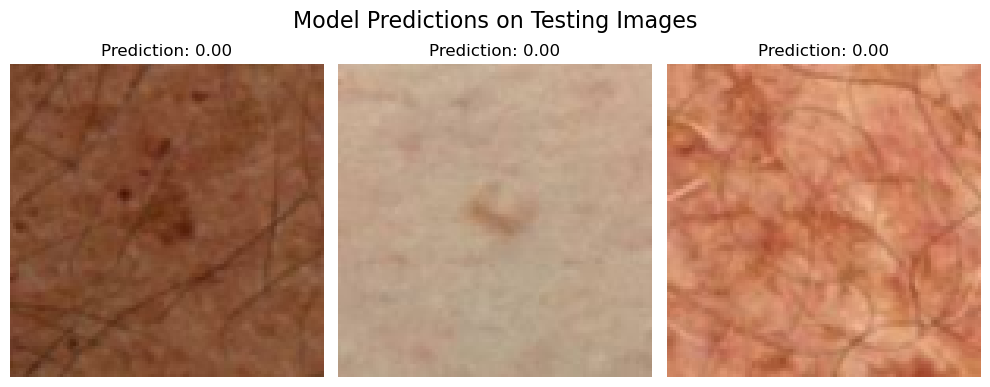

In [272]:
inputs = next(iter(testing_ds))
images = inputs["images"]

# Plotting
plt.figure(figsize=(10, 4))

for i in range(3):
    plt.subplot(1, 3, i+1)  # 1 row, 3 columns, i+1th subplot
    plt.imshow(images[i])  # Show image
    plt.title(f'Prediction: {preds[i]:.2f}')  # Set title with prediction
    plt.axis('off')  # Hide axis

plt.suptitle('Model Predictions on Testing Images', fontsize=16)
plt.tight_layout()
plt.show()

In [273]:
pred_df = testing_df[["isic_id"]].copy()
pred_df["target"] = preds.tolist()

sub_df = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')
sub_df = sub_df[["isic_id"]].copy()
sub_df = sub_df.merge(pred_df, on="isic_id", how="left")
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

,isic_id,target
0,ISIC_0015657,0.001304
1,ISIC_0015729,0.000001
2,ISIC_0015740,0.001244
